In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

# Time series & ML models
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Darts for modern time series models
from darts.models import RNNModel
from darts import TimeSeries
from darts.metrics import smape, mape


# Suppress warnings
warnings.filterwarnings("ignore")

# ========== LOAD DATA ==========
file_path = r"C:\Users\nguye\CODE\TimeSeries\BTL\Thang10_Thang11\ChiaNhom\Group\2019_Data_GroupA.csv"
chunksize = 100000
chunk_list = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    if 'event_time' not in chunk.columns or 'user_id' not in chunk.columns:
        continue
    chunk['event_time'] = pd.to_datetime(chunk['event_time'], errors='coerce')
    chunk = chunk.dropna(subset=['event_time', 'user_id'])
    chunk['date'] = chunk['event_time'].dt.date
    chunk_list.append(chunk[['user_id', 'date']])

df = pd.concat(chunk_list)

In [26]:
# Count daily active users
daily_active_users = df.groupby('date')['user_id'].nunique().reset_index()
daily_active_users.columns = ['date', 'active_users']
daily_active_users['date'] = pd.to_datetime(daily_active_users['date'])
daily_active_users = daily_active_users.sort_values('date')

# Split train/test
train_data = daily_active_users[daily_active_users['date'] < '2019-10-26']
test_data = daily_active_users[daily_active_users['date'] >= '2019-10-26']

# Darts time series
ts = TimeSeries.from_dataframe(daily_active_users, 'date', 'active_users')
ts_train = TimeSeries.from_dataframe(train_data, 'date', 'active_users')
ts_test = TimeSeries.from_dataframe(test_data, 'date', 'active_users')

In [27]:
# ========== ARIMA ==========
arima_model = ARIMA(train_data['active_users'], order=(2,1,2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))
arima_mae = mean_absolute_error(test_data['active_users'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test_data['active_users'], arima_forecast))

In [28]:
# ========== RNN (Simple Recurrent Neural Network) ==========
rnn = RNNModel(
    model='RNN',  # hoặc 'LSTM' / 'GRU' tùy bạn muốn
    input_chunk_length=14,
    output_chunk_length=len(ts_test),
    hidden_dim=32,
    n_rnn_layers=1,
    dropout=0.1,
    n_epochs=100,
    random_state=42
)

rnn.fit(ts_train)
rnn_forecast = rnn.predict(len(ts_test))
# Tính các độ đo
rnn_mae = mean_absolute_error(ts_test.values(), rnn_forecast.values())
rnn_rmse = np.sqrt(mean_squared_error(ts_test.values(), rnn_forecast.values()))
rnn_smape = smape(ts_test, rnn_forecast)
rnn_mape = mape(ts_test, rnn_forecast)


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 1.1 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [31]:
# ========== LSTM ==========
def create_lstm_dataset(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['active_users']].values)
test_scaled = scaler.transform(test_data[['active_users']].values)

window_size = 7
X_train, y_train = create_lstm_dataset(train_scaled.flatten(), window_size)
X_test, y_test = create_lstm_dataset(np.concatenate([train_scaled[-window_size:].flatten(), test_scaled.flatten()]), window_size)


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=100, verbose=0)

lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

true_values = test_data['active_users'].values
lstm_mae = mean_absolute_error(true_values, lstm_predictions[-len(true_values):])
lstm_rmse = np.sqrt(mean_squared_error(true_values, lstm_predictions[-len(true_values):]))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step



📊 Evaluation Metrics
---------------------
ARIMA - MAE: 6965.93, RMSE: 7654.82
LSTM  - MAE: 3783.41, RMSE: 4122.67
RNN   - MAE: 14260.80, RMSE: 14608.20, MAPE: 100.00, sMAPE: 199.99


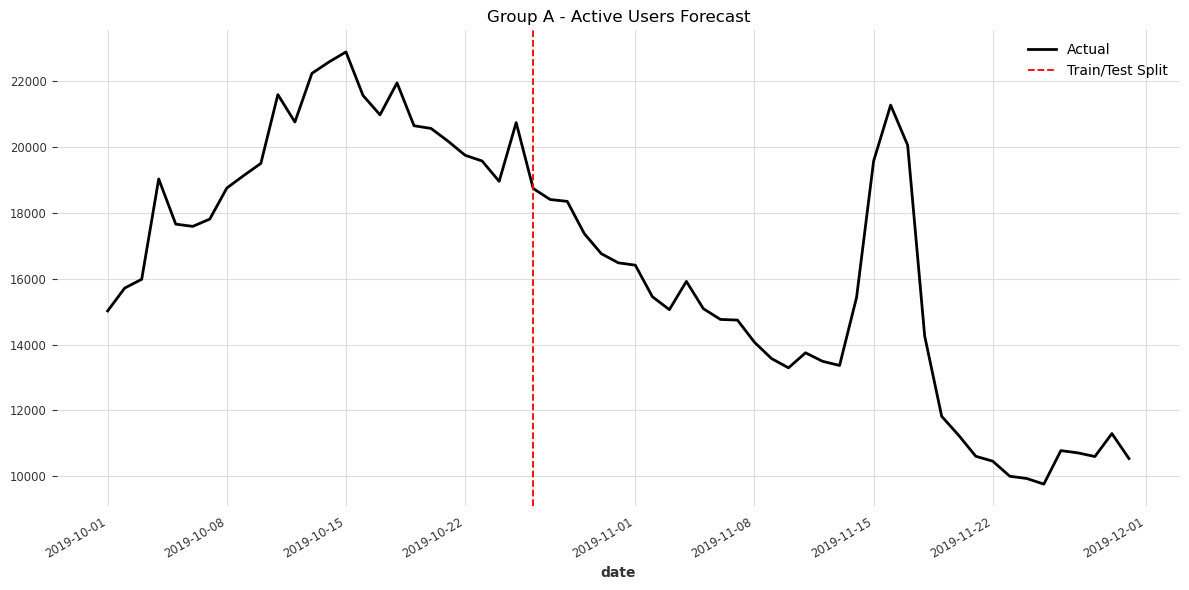

In [33]:
# ========== Evaluation ==========
print("\n📊 Evaluation Metrics")
print("---------------------")
print(f"ARIMA - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")
print(f"LSTM  - MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")
print(f"RNN   - MAE: {rnn_mae:.2f}, RMSE: {rnn_rmse:.2f}, MAPE: {rnn_mape:.2f}, sMAPE: {rnn_smape:.2f}")

# ========== Plot Forecast ==========
plt.figure(figsize=(12, 6))
ts.plot(label='Actual')

plt.axvline(pd.to_datetime('2019-10-26'), color='red', linestyle='--', label='Train/Test Split')
plt.title("Group A - Active Users Forecast")
plt.legend()
plt.tight_layout()
plt.show()


⚠️ TFT forecast not available, skipping TFT plot.


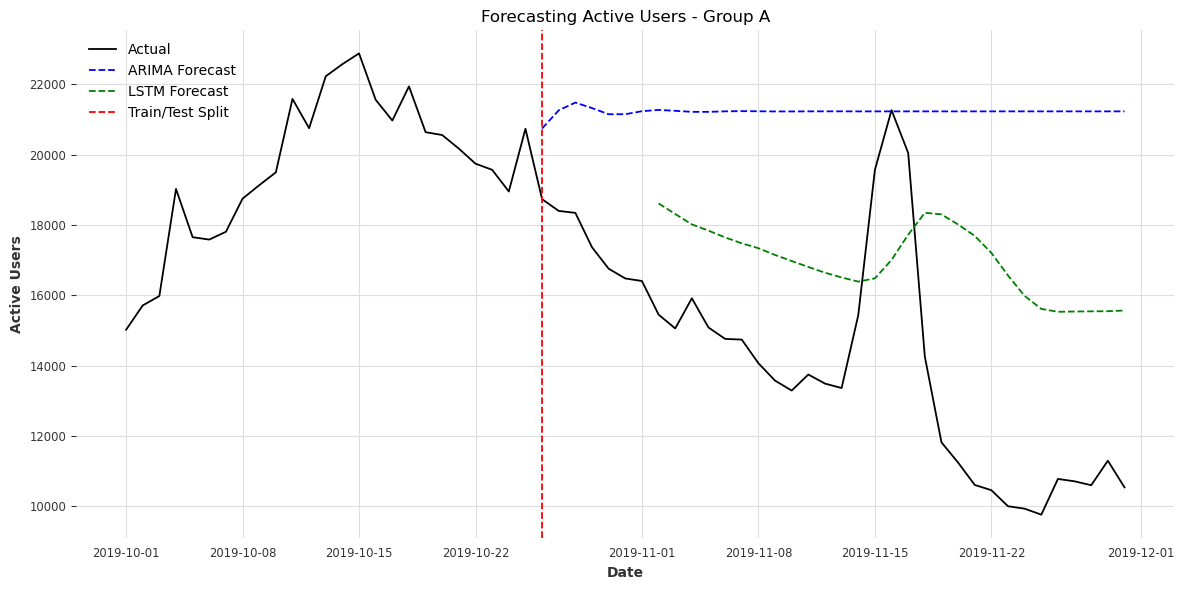

In [34]:
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu thực tế
plt.plot(daily_active_users['date'], daily_active_users['active_users'], label='Actual', color='black')

# Vẽ ARIMA
plt.plot(test_data['date'], arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')

# Vẽ LSTM (căn chỉnh để khớp số điểm)
plt.plot(test_data['date'][window_size:], lstm_predictions[-len(test_data)+window_size:], label='LSTM Forecast', linestyle='--', color='green')

# Vẽ TFT nếu tồn tại
try:
    tft_forecast.plot(label='TFT Forecast', lw=2, color='orange')
except:
    print("⚠️ TFT forecast not available, skipping TFT plot.")

# Thêm mốc tách train/test
plt.axvline(pd.to_datetime('2019-10-26'), color='red', linestyle='--', label='Train/Test Split')

# Giao diện biểu đồ
plt.title("Forecasting Active Users - Group A")
plt.xlabel("Date")
plt.ylabel("Active Users")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
